# Simulation d'observations de loi multinomiale 

Nous souhaitons simuler des observations d'une loi multinomiale: 

Considérons l'expérience où on extrait $n$ boules de $k$ différentes couleurs d'une urne avec remise. Les boules de la même couleur sont équivalents. Soit $X_i$ la variable qui compte le nombre de balles de couleur $i$ extraites ($i = 1, \cdots, k$), et soit $p_i$ la probabilité d'extraire une boule de couleur $i$. La probabilité de cette loi multinomiale est alors donnée part :

<math> \begin{align}
f(x_1,\ldots,x_k;n,p_1,\ldots,p_k) & {} = \mathbb{P}(X_1 = x_1, \dots, X_k = x_k) \\
& {} = \begin{cases} { \displaystyle {n! \over x_1!\cdots x_k!}p_1^{x_1}\times\cdots\times p_k^{x_k}}, \quad &
\text{quand } \sum_{i=1}^k x_i=n \\  \\
0 & \text{sinon} \end{cases}
\end{align}
</math>



## Algorithme de simulation : méthode de la fonction inverse

On peut voir une loi multinomiale comme la répétion de n expériences indépendantes à k issues possibles dont on a ensuite rassemblé les issues (compté le nombre de boules pour chaque couleur). On peut donc simuler chacune des expériences indépendamment. 

Pour générer une variable aléatoire discrète prenant pour valeur $1, \cdots, k$ avec proba $p_1, \cdots, p_k$ il suffit d'appliquer la méthode de la fonction inverse (avec inverse généralisée comme on est dans le cas discret). Plus clairement, on génére $U$ une variable aléatoire uniforme sur $[0,1]$ et on regarde dans quel "bins" on tombe, i.e, on calcule :  

$$j = \min \left\{ j' \in \{1,\dots,k\} : \left(\sum_{i=1}^{j'} p_i\right) - U \geq 0 \right\}$$

En répétant cette algorithme n fois et en rassamblant les issus on obtient une observation multinomiale. Nous présentons dans la cellule suivante l'algorithme "multinomial1" quie met en place cette statégie sans finesse. L'algorithme "multinomial2" est une version vectorisée, plus difficile à déchiffrer mais beaucoup plus rapide. Dans tous les cas on ne pourra pas battre les algos de numpy qui sont implémenté directement en C++.

In [3]:
import numpy as np 

### Version numpy

In [7]:
%%time
#Genere 100 observations multinomiale de paramètre n=1 milliard et p = [1./3,1./4,1./6,3./12]
mult = np.random.multinomial(1e9, [1./3,1./4,1./6,3./12], size=100)
print(mult.shape)
#On retrouve empiriquement les probas théoriques
print((mult/1e9)[:1,:])

(100, 4)
[[0.33334158 0.24998011 0.1666771  0.25000121]]
CPU times: user 574 µs, sys: 172 µs, total: 746 µs
Wall time: 562 µs


### Version simple

In [1]:
def multinomial1(n,prob,size=1,seed=42):
    """size = nombre d'observations multinomiale
    seed permet de fixer l'aléatoire
    
    Attention, meme si le vecteur en entré n'est pas trié, 
    la sortie est toujours trié par ordre décroissant"""
    
    np.random.seed(42)
     
    if abs(np.sum(prob)-1)>10e-16:
        return "Probabilités ne somment pas à 1"
    
    prob = np.sort(prob)[::-1] #tri par ordre décroissant, plus rapide
    
    u = np.random.uniform(size=n*size).reshape(size,n)
    output = np.zeros((size,len(prob)))
    for step in range(size):
        for el in u[step,:]:
            #pour chaque u on rejoute +1 pour la bins dans laquelle il tome
            output[step,get_bin(el,prob)] += 1
        
    return output
    
    
def get_bin(u,prob):
    '''Permet d'obtenir la bins dans laquelle tome un element selon un vecteur de proba'''
    cumprob = np.cumsum(prob)
    for i,p in enumerate(cumprob):
        if u<p:
            return i

In [8]:
%%time
n = int(1e5)
test = multinomial1(n,np.array([1./3,1./4,1./6,3./12]),size=20)
#print(test/float(n))

CPU times: user 5.25 s, sys: 58 ms, total: 5.31 s
Wall time: 5.49 s


### Version vectorisée

In [9]:
def multinomial2(n,prob,size=1,seed=42):
    """Genere une loi multinomiale, approche plus vectorielle que la premiere
    size = nombre d'observations multinomiale
    seed permet de fixer l'aléatoire
    
    Attention, meme si le vecteur en entré n'est pas trié, 
    la sortie est toujours trié par ordre décroissant"""
    
    np.random.seed(seed)
     
    if abs(np.sum(prob)-1)>10e-16:
        return "Probabilités ne somment pas à 1"
    
    prob = np.sort(prob)[::-1] 
    
    u = np.random.uniform(size=n*size).reshape(size,n)
    output = np.zeros((size,len(prob)))
    
    cprob = np.cumsum(prob)
    
    for i,p in enumerate(cprob):
        if i==0:
            output[:,i] = (u<cprob[i]).sum(axis=1)
        else : 
            output[:,i] = ((u<cprob[i]) & (u>=cprob[i-1])).sum(axis=1)
   # output = np.concatenate((output[:,0].reshape(-1,1),np.diff(output,axis=1)),axis=1)
        
    return output

In [10]:
%%time
n = int(1e5)
test = multinomial2(n,np.array([1./3,1./4,1./6,3./12]),size=20)
print((test/float(n))[:4,:])

[[0.33439 0.24914 0.25124 0.16523]
 [0.33104 0.25022 0.25053 0.16821]
 [0.333   0.24922 0.25067 0.16711]
 [0.33536 0.2493  0.24995 0.16539]]
CPU times: user 52.3 ms, sys: 7.91 ms, total: 60.2 ms
Wall time: 89.2 ms


Beaucoup plus rapide ! Pour l'application de la CE méthode au problème TSP nous utiliserons les fonctions numpy np.choice et np.random.multinomial bien plus rapides que les notres.

# TSP problem using CE Method 

In [11]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations

## Classe TSP

In [12]:
class TSP(object):
    """Classe permettant de résoudre un problème TSP, deux versions sont disponibles :
        -la version originale proposée par les auteurs de la méthode (avec un smooth update possible)
        -une version considérant une approche bayésienne
    
    Attributs à entrer par l'utilisateur:
        c: matrice de poids pour les trajets entre les villes.
        methode: au choix entre "CE" pour la 1ere version et "Bayes" pour la 2nd
        k: nombre de simulations pour chaque update de la forme k*(nombre villes)^2 
        perc: percentile fixé dans l'algo (int entre 1 et 100) 
        seed: graine pour fixer l'aléatoire 
        stop: critère d'arrêt (on s'arrète quand les d derniers quantiles sont les mêmes)
        alpha: "smoothing" parameter (1ere version only)
        
    Attributs:
        n: nombre de villes
        N: nombre de simulations pour chaque update
        p: matrice de transition entre les villes (pij proba de passer de la ville i à la ville j),
           initialisée par des Dirichlet uniformes
        p_old: version de p de l'update précédent (1ere version only)
        r: matrice des paramètres de Dirichlet (chaque ligne correspond à une Dirichlet), 
           initialisée avec alpha=1 (2eme version only)
        r_old: version de r de l'update précédent (2eme version only)
        solution: sauvegarde la tour optimal
        show_p: fréquence d'affichage de la matrice de transition en output
        show_q: fréquence d'affichage du plot des quantiles en output
        
        
    Méthodes: (Voir aide spécifique à chaque méthode pour plus de détails)
    """
    
    def __init__(self, c, methode="CE", k=10, perc=1, alpha=0.9, seed=None, stop=5, show_p=5,show_q=10):
        """Constructeur de la classe TSPBayes"""
        
        if methode not in ["CE","Bayes"]:
            print("Mauvaise méthode, méthodes disponibles : Bayes, CE")
            sys.exit(1)
            
        self.c = c
        self.methode = methode
        self.n = c.shape[0]
        self.N = k * self.n**2
        self.perc = perc
        self.seed = seed
        self.stop = stop
        self.solution = None
        self.show_p = show_p
        self.show_q = show_q
        if self.methode=="CE":
            self.alpha = alpha
            self.p=(np.ones((self.n,self.n))-np.eye(self.n))*(1/float(self.n-1))
            self.p_old = self.p
            
        if self.methode=="Bayes":
            self.p = self.p_init()
            self.r = np.ones((self.n,self.n)) - np.eye(self.n)
            self.r_old = self.r

    def gen_dir(self,alpha):
        '''Simule 1 observation de loi de Dirichlet. (2eme version only)
        Ne prend en compte que les paramètres positifs'''
        
        alpha = alpha[alpha>0]
        
        return np.random.dirichlet(alpha,1)
        

    def p_init(self):
        """Initialise la matrice p avec des Dirichlet uniformes (2eme version only)
        Chaque ligne est simulée selon une Dirichlet(1,...,1) 
        """
        
        p = np.zeros((self.n,self.n))
        
        for i in range(self.n):
            
            row = self.gen_dir(np.tile(1,self.n-1))
            #On insert des 0 car la matrice p ne doit contenir que des 0 sur sa diagonale
            row = np.insert(row,i,0)
            p[i,:] = row

        return p
        
    def generate_tours(self):
        """Génère N tours selon les probabilités de transition de p
        Retourne une matrice de taille N*n où chaque ligne est un tour"""
    
        #première ville toujours 0 (mieux de prendre 0 que 1 pour les indices des matrices)
        #Fixer la ville de départ se fait sans perte de généralité
        tours = np.zeros((self.N,(self.n+1)),dtype=int)

        for obs in range(self.N):
            
            p = self.p.copy()
            
            for step in range(1,(self.n)):
                
                #colonne dernière ville du tour mise à 0 pour qu'on n'y repasse pas
                p[:,tours[obs,(step-1)]] = 0 
                
                with np.errstate(invalid='ignore', divide='ignore'): 
                    p = (np.divide(p.T,p.sum(axis=1))).T #renormalise pour que les colonnes somment à 1
                
                #génère une multinomiale(1,p1,...,pn) pour trouver la prochaine ville
                tours[obs,step] = np.random.choice(np.arange(self.n),1, p=p[tours[obs,(step-1)],:])[0]
                
            tours[obs,-1] = 0 #retour à la ville 0 (départ)
            
        return tours
        
    def S(self,x):
        '''Calcule la performance du tour par rapport à la matrice de poids c
        Performance = somme des distances parcourues entre les villes'''
        
        score = 0
        for i in range(len(x)-1):
            score += self.c[x[i],x[i+1]] #cout d'aller d'une ville à une autre 

        return score
    
    def construct_mult(self,x,score,q):
        '''Construction des observations multinomiales à partir des tours, 
        de leur score et du quantile (2eme version only)'''
        
        m =  np.zeros_like(self.r)
    
        x = x[score<=q,:]
        
        for obs in range(x.shape[0]):
            
            for idx in range(x.shape[1]-1):
                i = x[obs,idx]
                j = x[obs,idx+1]
                m[i,j] += 1
   
        return m

    
    def update_Bayes(self,x,score,q):
        '''Update bayésien de la matrice p. (2eme version only)
        Calcul des nouveau coefficients des Dirichlet par la formule de Bayes 
        simulation de la nouvelle matrice p par ces lois Dirichlet'''
        
        r_temp = self.r.copy()
        self.r = self.construct_mult(x,score,q)
        self.r_old = r_temp
        
        self.r = self.r + self.r_old
        
        p = np.zeros((self.n,self.n))
        
        for i in range(self.n):
            
            u = self.gen_dir(self.r[i,:])
            u = np.insert(u,i,0)
            p[i,:] = u
            
        self.p = p
            
        return None
    
    def update_CE(self,x, score,q):
        '''Permet de faire l'update "smooth" des probas de transition pij (1ere version only)
        la methode "smooth" evite les problemes avec des 0 au mauvais endroits'''
        self.p_old = self.p.copy()
        p =  np.zeros_like(self.p)
        
        x = x[score<=q,:]
        
        for obs in range(x.shape[0]):
            
            for idx in range(x.shape[1]-1):
                i = x[obs,idx]
                j = x[obs,idx+1]
                p[i,j] += 1

        p = np.divide(p,float(x.shape[0]))
        
        self.p = self.alpha*p + (1-self.alpha)*self.p_old
             
        return None
    
    
    def show_prob(self):
        '''Affiche p sous forme de HeatMap'''
        
        plt.figure(figsize=(8,8))
        plt.matshow(self.p,fignum=1)
        plt.xlabel('j')
        plt.ylabel('i')
        plt.grid('off')
        plt.colorbar()
        plt.show()
    
 
    def CE_fit(self):
        
        if self.seed: 
         #fixe aléa
         np.random.seed(self.seed)
         
        #Critére d'arrêt : les 'stop' derniers quantiles calculés sont les mêmes, q_memory les stockent
        #q_memory = np.zeros(self.stop)
        q_memory = np.array([])
        
        epoch = 0
        best_score = np.infty
        
        print("Vous utilisez la méthode : {}".format(self.methode))
        
        while True:
            epoch += 1
            print("Epoch {}".format(epoch))
            
            #genere les "tours"
            x = self.generate_tours().astype(np.int)
            
            #calcul du score pour chaque tour
            score = np.apply_along_axis(lambda x: self.S(x),1,x)
            
            #quantile
            q = np.percentile(score,self.perc)
            
            best = np.min(score)
            if best < best_score: 
                best_score = best
                self.solution = x[np.argmin(score),:]
                
            print("Quantile : {}, Meilleur score : {}".format(q,best))
            
            q_memory = np.append(q_memory,[q])
                        
            if epoch%self.show_p==0: 
                self.show_prob()
                
            if epoch%self.show_q==0: 
                plt.plot(q_memory)
                plt.show()
            
            if self.methode=="CE":
                #smooth update
                self.update_CE(x,score,q)
                
            if self.methode=="Bayes":
                self.update_Bayes(x,score,q)
                
            #si les 5 derniers quantiles sont les mêmes ont arrête
            if len(q_memory)>5:
                if len(set(q_memory[-self.stop:]))==1 : break  
        
        #Affichage finale
        self.show_prob()
        plt.plot(q_memory)
        plt.show()
        print("final epoch {}, dernier quantile : {}".format(epoch,q))
        print("Meilleur score {}, solution : {}".format(best_score,self.solution))
                
        return

## Fonctions d'aide

In [13]:
def get_distance_from_cartesian(arr):
    '''Fonction permettant de calculer la matrice des distances à partir d'une liste de coordonnées cartésiennes'''
    
    n = arr.shape[0]
    c = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i,n):
            c[i,j] = np.sqrt((arr[i,0]-arr[j,0])**2 + (arr[i,1]-arr[j,1])**2)
            
    c += c.T
    
    return c

In [14]:
from math import sin, cos, sqrt, atan2, radians

def get_distance_from_geographic(arr):
    '''Fonction permettant de calculer la matrice des distances à partir d'une liste
    de latitudes et longitudes'''
    
    # approximate radius of earth in km
    R = 6373.0
    n = arr.shape[0]
    distance_mat = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i,n):
        
            lat1 = radians(arr[i,0])
            lon1 = radians(arr[i,1])
            lat2 = radians(arr[j,0])
            lon2 = radians(arr[j,1])
            
            dlon = lon2 - lon1
            dlat = lat2 - lat1

            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance = R * c
            distance_mat[i,j] = distance
            
    distance_mat += distance_mat.T
    
    return distance_mat

In [15]:
def CE_solution(c,method="CE",k=10,perc=1,alpha=0.9):
    '''Fit la classe TSP sur un matrice de distances c'''
    
    tsp = TSP(c,k=k,perc=perc,methode=method,alpha=alpha)
    tsp.CE_fit()
    return tsp

In [16]:
def plot_solution_cartesian(tsp,d):
    '''
    Plot la solution du tour optimal pour des points de coordonnées cartésiennes
    
    tsp : objet TSP fitté, 
    d :  matrice contenant les coordonnées cartésiennes'''

    #Ensemble de points
    print("Ensemble des villes dans le plan")
    plt.plot(d[:,0],d[:,1],".")
    plt.axis("off")
    plt.show()
    
    #Solution
    print("Trajet optimal")
    permut = tsp.solution
    plt.plot(my_data[permut,0],my_data[permut,1])
    plt.axis("off")
    plt.show()

## Example à 10 villes

In [19]:
my_data = np.genfromtxt('tiny.csv', delimiter=',')
print(my_data.shape)
my_data

(10, 2)


array([[-1.0856306 , -0.67888615],
       [ 0.99734545, -0.09470897],
       [ 0.2829785 ,  1.49138963],
       [-1.50629471, -0.638902  ],
       [-0.57860025, -0.44398196],
       [ 1.65143654, -0.43435128],
       [-2.42667924,  2.20593008],
       [-0.42891263,  2.18678609],
       [ 1.26593626,  1.0040539 ],
       [-0.8667404 ,  0.3861864 ]])

In [20]:
#on récupères les distance à partir des coordonnées cartésiennes
c = get_distance_from_cartesian(my_data)
c.shape

(10, 10)

### Solution SmoothUpdate

L'algorithme affiche pour chaque update le quantile calculé sur les scores et le meilleure score.

Toutes les 5 updates la matrice de transition P (de plus en plus sparse).

Tous les 10 updates le plot de l'évolution est quantiles.

Vous utilisez la méthode : CE
Epoch 1
Quantile : 17.0378308936, Meilleur score : 15.5921232795
Epoch 2
Quantile : 13.6610608807, Meilleur score : 12.7852228494
Epoch 3
Quantile : 12.5169780398, Meilleur score : 12.5169780398
Epoch 4
Quantile : 12.5169780398, Meilleur score : 12.5169780398
Epoch 5
Quantile : 12.5169780398, Meilleur score : 12.5169780398


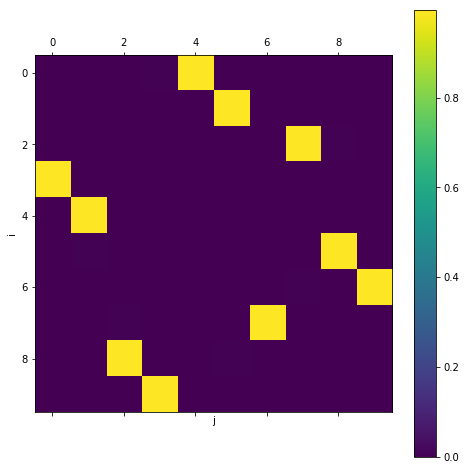

Epoch 6
Quantile : 12.5169780398, Meilleur score : 12.5169780398
Epoch 7
Quantile : 12.5169780398, Meilleur score : 12.5169780398


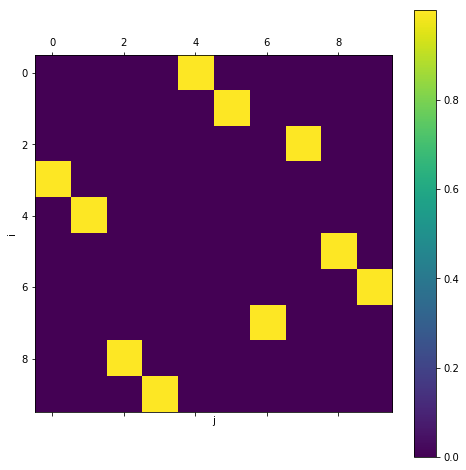

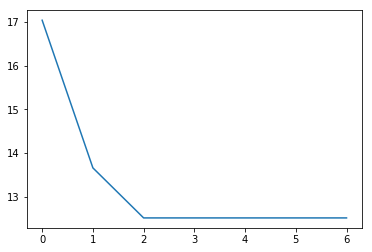

final epoch 7, dernier quantile : 12.5169780398
Meilleur score 12.5169780398, solution : [0 4 1 5 8 2 7 6 9 3 0]
CPU times: user 4.36 s, sys: 111 ms, total: 4.47 s
Wall time: 4.05 s


In [29]:
%%time
tsp1 = CE_solution(c,method="CE")

In [30]:
print(tsp1.solution)

[0 4 1 5 8 2 7 6 9 3 0]


Ensemble des villes dans le plan


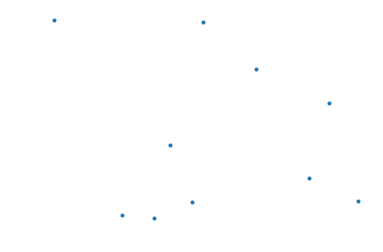

Trajet optimal


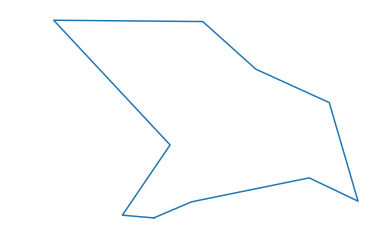

In [31]:
plot_solution_cartesian(tsp1,my_data)

### Solution Bayésienne

Vous utilisez la méthode : Bayes
Epoch 1
Quantile : 17.1710174403, Meilleur score : 14.4618153458
Epoch 2
Quantile : 15.0809003788, Meilleur score : 13.5915256384
Epoch 3
Quantile : 13.5915256384, Meilleur score : 12.5169780398
Epoch 4
Quantile : 12.7852228494, Meilleur score : 12.5169780398
Epoch 5
Quantile : 12.5169780398, Meilleur score : 12.5169780398


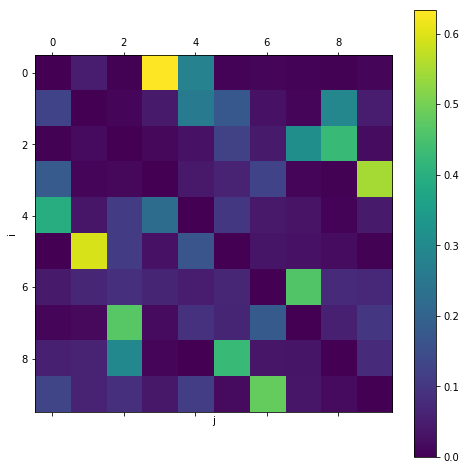

Epoch 6
Quantile : 12.5169780398, Meilleur score : 12.5169780398
Epoch 7
Quantile : 12.5169780398, Meilleur score : 12.5169780398
Epoch 8
Quantile : 12.5169780398, Meilleur score : 12.5169780398
Epoch 9
Quantile : 12.5169780398, Meilleur score : 12.5169780398


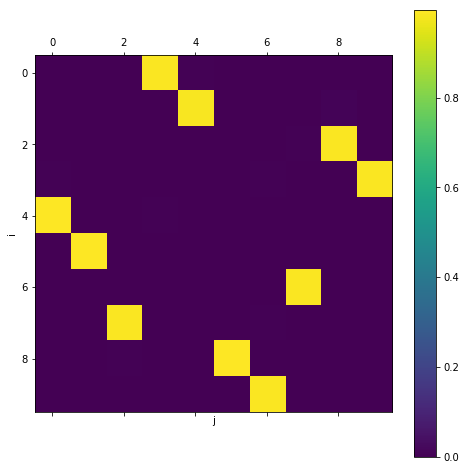

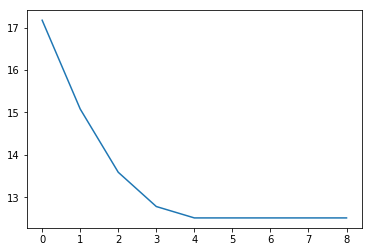

final epoch 9, dernier quantile : 12.5169780398
Meilleur score 12.5169780398, solution : [0 3 9 6 7 2 8 5 1 4 0]
CPU times: user 5.67 s, sys: 138 ms, total: 5.81 s
Wall time: 5.5 s


In [32]:
%%time
tsp2 = CE_solution(c,method="Bayes")

In [33]:
print(tsp2.solution)

[0 3 9 6 7 2 8 5 1 4 0]


Ensemble des villes dans le plan


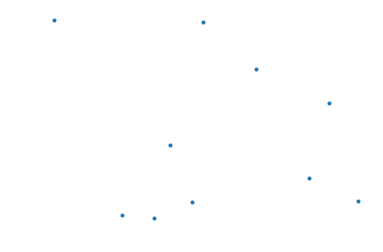

Trajet optimal


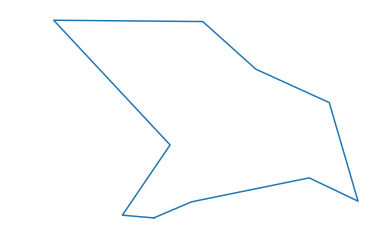

In [34]:
plot_solution_cartesian(tsp1,my_data)

On retrouve la même solution par les deux approches. Cependant quand on augmente le nombre de villes (plus de 20), l'approche bayésienne est très lente à converger.

## Tour du monde des capitales

worldtour.csv contient des données sur 217 capitales triées par ordre croissant de leur population
Leur latitude et longitude permet de reconstruire la matrice des distances.

In [41]:
df_a = pd.read_csv("worldtour.csv")
df_a.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Hagåtña,Hagta,13.4745,144.7504,Guam,GU,GUM,NaN,primary,1051.0,1316937540
1,Stanley,Stanley,-51.7000,-57.8500,Falkland Islands (Islas Malvinas),FK,FLK,NaN,primary,2213.0,1238780509
2,Capitol Hill,Capitol Hill,15.2137,145.7546,Northern Mariana Islands,MP,MNP,NaN,primary,2500.0,1580556972
3,George Town,George Town,19.2804,-81.3300,Cayman Islands,KY,CYM,NaN,primary,4268.0,1136159124
4,Palikir,Palikir,6.9166,158.1500,"Micronesia, Federated States Of",FM,FSM,Pohnpei,primary,4645.0,1583008885


In [42]:
p = 25 #on fixe ici le nombre des villes retenues
df = df_a.copy()
df = df[-p:]
df.shape

(25, 11)

In [43]:
#On construit la matrice des distances à partir des coordonnée géographiques
my_data = df[["lat","lng"]].values
c = get_distance_from_geographic(my_data)
c.shape

(25, 25)

### Smooth Update 25 villes

Vous utilisez la méthode : CE
Epoch 1
Quantile : 174934.33211, Meilleur score : 151556.613003
Epoch 2
Quantile : 132269.699123, Meilleur score : 109826.710067
Epoch 3
Quantile : 105636.061888, Meilleur score : 89448.7156633
Epoch 4
Quantile : 89979.1354876, Meilleur score : 80537.4643582
Epoch 5
Quantile : 79793.7678538, Meilleur score : 71411.5225864


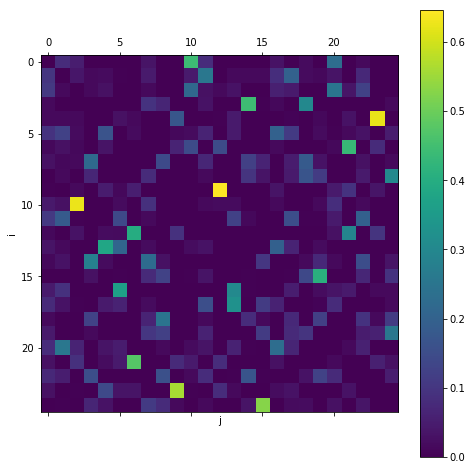

Epoch 6
Quantile : 73652.8895393, Meilleur score : 66309.7456098
Epoch 7
Quantile : 67954.7617617, Meilleur score : 59976.4652319
Epoch 8
Quantile : 59976.4652319, Meilleur score : 59974.6342332
Epoch 9
Quantile : 59976.4652319, Meilleur score : 59974.6342332
Epoch 10
Quantile : 59976.4652319, Meilleur score : 59974.6342332


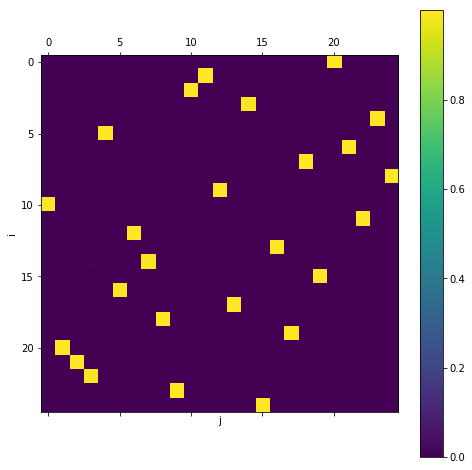

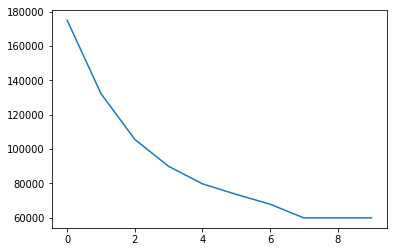

Epoch 11
Quantile : 59976.4652319, Meilleur score : 59976.4652319
Epoch 12
Quantile : 59976.4652319, Meilleur score : 59976.4652319


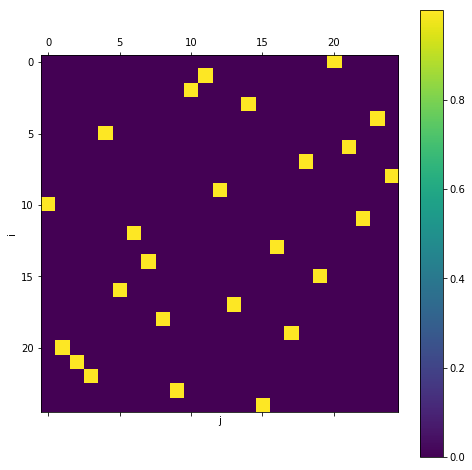

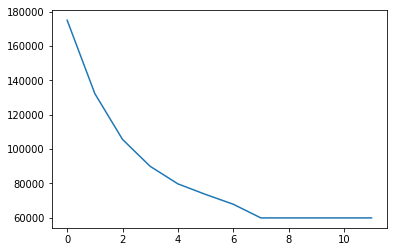

final epoch 12, dernier quantile : 59976.4652319
Meilleur score 59974.6342332, solution : [ 0 20  1 11 22 14  3  7 18  8 24 15 19 17 13 16  5  4 23  9 12  6 21  2
 10  0]
CPU times: user 1min 50s, sys: 919 ms, total: 1min 51s
Wall time: 1min 52s


In [46]:
%%time
tsp_Smooth = CE_solution(c,method="CE")

In [47]:
print(tsp_Smooth.solution)

[ 0 20  1 11 22 14  3  7 18  8 24 15 19 17 13 16  5  4 23  9 12  6 21  2
 10  0]


### Bayésien 25 villes

Avec 25 villes l'algorithme met plusieurs heures à converger, avec plus de 500 updates. Avec plus de 25 villes il est préférable d'utilser le Smooth Update.

In [ ]:
%%time
tsp_Bayes = CE_solution(c,method="Bayes")

### Affichage solution avec Folium

Folium est un package permettant de gérer des cartes interactive. On représente le tour optimal sur une carte du monde

In [50]:
import folium

In [51]:
def plot_my_world_tour(permut,df,line=True):
    '''
    permut : contient une tour optimal
    df: contient le worldwide.csv avec les villes sélectionnées
    line=True: if True trace les transitions entre les villes
    '''
    
    locations = df.iloc[permut,:][['lat', 'lng']]
    names = df.iloc[permut,:]['city_ascii']
    locationlist = locations.values.tolist()

    #centre la map sur Paris
    map_osm = folium.Map(location=[48.82, 2.26],zoom_start=1.5)

    #affiche les villesp points pas points
    for point in range(0, len(locationlist)):
        folium.Marker(locationlist[point], popup=names.iloc[point]).add_to(map_osm)
        
    #relie les villes entre elles selon le tour optimal
    if line:
        folium.PolyLine(locationlist).add_to(map_osm)

    #map_osm.save("map3.html")

    return map_osm

In [52]:
# Ville sans trajet
plot_my_world_tour(tsp_Smooth.solution,df,line=False)

In [57]:
# Tour optimal
plot_my_world_tour(tsp_Smooth.solution,df)

### Solution tour du monde 50 villes

Avec 50 villes la solution est obtenue en 38 minutes avec le Smooth update et la solution est donnée ci-dessous.

In [58]:
p = 50 #on fixe ici le nombre des villes retenues
df2 = df_a.copy()
df2 = df2[-p:]
df2.shape

(50, 11)

In [59]:
#On construit la matrice des distances à partir des coordonnée géographiques
my_data2 = df2[["lat","lng"]].values
c2 = get_distance_from_geographic(my_data2)
c2.shape

(50, 50)

In [ ]:
%%time
tsp_Smooth_50 = CE_solution(c2,method="CE")

In [60]:
#Solution
l = [0, 10, 34, 37, 31, 46, 21, 6, 8, 30, 18, 4, 2, 14, 20, 5, 45, 25, 35, 27,
    13, 9, 11, 12, 24, 26, 36, 15, 47, 22, 32, 23, 44, 16, 40, 49, 33, 43, 39,
    28, 1, 42, 7, 19, 3, 17, 41, 38, 29, 48, 0]

In [62]:
plot_my_world_tour(l,df2)